In [67]:
library(survey)
library(RPostgreSQL)
library(twang)
library(Matching)
library(tidyverse)
library(readxl)
library(rms)
library(survey)
library(ggplot2)

In [68]:
data_dir <- file.path("..", "data")

In [69]:
full_data <- readRDS(file.path(data_dir, "full_data_ps.rds"))
head(full_data)

,stay_id,hadm_id,subject_id,gender,age,sapsii,icu_intime,icu_outtime,weight,sofa_24hours,⋯,lab_potassium_flag,lab_troponin_flag,lab_po2_flag,lab_lactate_flag,gcs_int,ca_int,event_state_int,mort_28_day_int,ps,ps_weight
,<int>,<int>,<int>,<fct>,<dbl>,<int>,<dttm>,<dttm>,<dbl>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,38302142,20475690,13620446,F,66.04835,31,2159-01-21 01:45:32,2159-01-25 14:09:02,138.0,1,⋯,1,0,1,1,0,1,1,0,0.24414645,1.323008
2,31869153,21383344,15359363,F,41.91122,39,2166-12-02 16:08:45,2166-12-05 02:10:02,70.0,0,⋯,1,0,0,0,1,NA,0,0,0.49112332,2.036148
3,31501167,20944291,12162143,F,87.59137,35,2174-08-05 00:49:12,2174-08-06 16:13:22,65.0,1,⋯,1,0,1,1,0,1,0,0,0.06747939,1.072362
4,39256124,24959920,18226317,M,66.88656,28,2130-11-20 19:28:29,2130-11-25 12:42:59,88.0,3,⋯,1,0,0,0,0,1,0,0,0.07645528,1.082785
5,31132695,28164203,15928453,F,44.39155,55,2113-05-24 00:14:32,2113-05-29 14:24:45,45.9,10,⋯,1,0,1,1,0,1,1,0,0.05389380,1.056964
6,39784690,23246205,16810503,M,56.61848,30,2149-08-14 21:32:37,2149-08-21 12:15:14,80.0,3,⋯,1,0,1,1,0,1,0,0,0.03894196,1.040520


In [70]:
wtd_pval <- data.table::fread(file.path(data_dir, "wtd_pval.csv"), data.table = FALSE)
print(wtd_pval)

                          cov  pval
1                         age 0.228
2                      gender 0.189
3                      weight 0.979
4                      sapsii 0.492
5                sofa_24hours 0.045
6                 mort_28_day 0.480
7               survival_days 0.025
8              infection_flag 0.324
9                vs_map_first 0.957
10        vs_heart_rate_first 0.960
11              vs_temp_first 0.804
12              lab_wbc_first 0.187
13       lab_hemoglobin_first 0.143
14         lab_platelet_first 0.579
15           lab_sodium_first 0.672
16        lab_potassium_first 0.991
17      lab_bicarbonate_first 0.151
18         lab_chloride_first 0.762
19              lab_bun_first 0.875
20          lab_lactate_first 0.231
21       lab_creatinine_first 0.113
22               lab_ph_first 0.022
23              lab_po2_first 0.399
24             lab_pco2_first 0.583
25               lab_bnp_flag 0.635
26          lab_troponin_flag 0.454
27 lab_creatinine_kinase_fla

In [71]:
wpv <- wtd_pval %>%
    filter(pval < 0.1) %>%
    pull(cov)

wpv

[1] "sofa_24hours"  "survival_days" "lab_ph_first"

In [72]:
ipw_svydesign <- readRDS(file.path(data_dir, "ipw_svydesign.rds"))

In [73]:
fml <- wpv %>%
c("gcs", .) %>%
paste(collapse = " + ") %>%
sprintf("mort_28_day ~ %s", .)

fml



[1] "mort_28_day ~ gcs + sofa_24hours + survival_days + lab_ph_first"

In [74]:
fml <- mort_28_day ~ gcs + sofa_24hours + vs_cvp_flag + lab_ph_first

In [75]:
logi <- svyglm(as.formula(fml), family = quasibinomial, design = ipw_svydesign)

In [76]:
summary(logi)


Call:
svyglm(formula = as.formula(fml), design = ipw_svydesign, family = quasibinomial)

Survey design:
svydesign(ids = ~stay_id, weights = ~ps_weight, data = full_data)

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.21726    7.08912   0.736    0.462    
gcs1         -0.15575    0.21538  -0.723    0.470    
sofa_24hours  0.27538    0.03056   9.012  < 2e-16 ***
vs_cvp_flag1 -1.15630    0.22388  -5.165 2.58e-07 ***
lab_ph_first -1.13131    0.95887  -1.180    0.238    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasibinomial family taken to be 1.001487)

Number of Fisher Scoring iterations: 5


In [77]:
exp(cbind(OR = coef(logi), confint(logi)))

,OR,2.5 %,97.5 %
(Intercept),184.4279995,0.0001693869,2.008047e+08
gcs1,0.8557723,0.5609752133,1.305488e+00
sofa_24hours,1.3170322,1.2404326432,1.398362e+00
vs_cvp_flag1,0.3146470,0.2028488070,4.880618e-01
lab_ph_first,0.3226112,0.0492183892,2.114616e+00


In [78]:
fml <- mort_28_day ~ gcs + sofa_24hours + vs_cvp_flag + lab_ph_first + cumulative_dose


In [79]:
full_data$cumulative_dose <- ifelse(is.na(full_data$cumulative_dose), 0, full_data$cumulative_dose)
str(full_data$cumulative_dose)

 num [1:4401] 0 1450 0 0 0 0 920 0 0 0 ...


In [80]:
full_data$dose_group <- cut(full_data$cumulative_dose, 
                           breaks = c(0, 1888, Inf), 
                           labels = c("Low", "High"))

# 将 NA 值替换为 0
full_data$dose_group <- ifelse(is.na(full_data$dose_group), 0, full_data$dose_group)

In [81]:


str(full_data$dose_group)

 num [1:4401] 0 1 0 0 0 0 1 0 0 0 ...


In [82]:
fml <- mort_28_day ~ gcs + sofa_24hours + vs_cvp_flag + lab_ph_first + dose_group

In [83]:
unweighted <- glm(as.formula(fml), data = full_data, family = binomial, na.action = na.exclude)
summary(unweighted)
exp(cbind(OR = coef(unweighted), confint(unweighted)))


Call:
glm(formula = as.formula(fml), family = binomial, data = full_data, 
    na.action = na.exclude)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  10.33137    4.56295   2.264  0.02356 *  
gcs1         -0.14964    0.53180  -0.281  0.77842    
sofa_24hours  0.26853    0.01856  14.466  < 2e-16 ***
vs_cvp_flag1 -1.14418    0.15035  -7.610 2.74e-14 ***
lab_ph_first -1.82601    0.61924  -2.949  0.00319 ** 
dose_group    0.25747    0.41390   0.622  0.53390    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1978.5  on 2735  degrees of freedom
Residual deviance: 1677.2  on 2730  degrees of freedom
  (1665 observations deleted due to missingness)
AIC: 1689.2

Number of Fisher Scoring iterations: 5


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),3.068020e+04,3.78064891,2.262443e+08
gcs1,8.610195e-01,0.30049773,2.434766e+00
sofa_24hours,1.308047e+00,1.26186570,1.357184e+00
vs_cvp_flag1,3.184854e-01,0.23576480,4.253238e-01
lab_ph_first,1.610543e-01,0.04804869,5.458854e-01
dose_group,1.293656e+00,0.55880431,2.853296e+00


In [84]:

library(rms)
library(survey)
library(ggplot2)


In [85]:
m1 <- read_excel(file.path(data_dir, "rcs.xlsx"))
head(m1)

mort_28_day,survival_days,cumulative_dose,gcs,dose_val_rx_average,pre_dose_val_rx
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,222.627164,316,1,3,4
0,1.703252,NA,0,10,NA
0,1695.817130,NA,0,NA,NA
0,1.117257,2140,1,100,20
0,1.823623,NA,0,NA,NA
0,4.109074,NA,0,NA,NA


In [86]:
 
 dd <- datadist(m1) 
 head(m1) 

mort_28_day,survival_days,cumulative_dose,gcs,dose_val_rx_average,pre_dose_val_rx
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,222.627164,316,1,3,4
0,1.703252,NA,0,10,NA
0,1695.817130,NA,0,NA,NA
0,1.117257,2140,1,100,20
0,1.823623,NA,0,NA,NA
0,4.109074,NA,0,NA,NA


In [87]:
options(datadist='dd') 

In [88]:

m3<- cph(Surv(survival_days, mort_28_day) ~ rcs(pre_dose_val_rx,4),x=TRUE , y=TRUE,data = m1) 

In [89]:
anova(m3) 

,Chi-Square,d.f.,P
pre_dose_val_rx,8.584875,3,0.03535101
Nonlinear,8.092985,2,0.01748359
TOTAL,8.584875,3,0.03535101


In [124]:
HR<-Predict(m3,pre_dose_val_rx,fun=exp,ref.zero = TRUE ) 
View(HR)

pre_dose_val_rx,yhat,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
1.000000,2.5057008,0.7449735,8.427865
1.497487,2.2886913,0.7560270,6.928467
1.994975,2.0904763,0.7671661,5.696408
2.492462,1.9094500,0.7783621,4.684194
2.989950,1.7453270,0.7896001,3.857860
3.487437,1.5992082,0.8009031,3.193229
3.984925,1.4715862,0.8123072,2.665945
4.482412,1.3624224,0.8238693,2.253021
4.979899,1.2713818,0.8356891,1.934226


In [125]:
find_non_crossing_intervals <- function(df) {
  df_filtered <- df[(df$lower > 1 & df$upper > 1) | (df$lower < 1 & df$upper < 1), ]
  return(df_filtered)
}

HR_filtered <- find_non_crossing_intervals(HR)
HR_filtered

,pre_dose_val_rx,yhat,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
23,11.94472,1.063770,1.000460,1.131086
24,12.44221,1.088865,1.007269,1.177070
25,12.93970,1.116818,1.015216,1.228588
26,13.43719,1.147221,1.023822,1.285494
27,13.93467,1.179621,1.032729,1.347406
28,14.43216,1.213506,1.041666,1.413694
29,14.92965,1.248303,1.050418,1.483466
30,15.42714,1.283436,1.058828,1.555690
31,15.92462,1.318713,1.066901,1.629958


In [126]:
HR <- Predict(m3, pre_dose_val_rx = 44.5, fun = exp, ref.zero = TRUE)
HR

pre_dose_val_rx,yhat,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
44.5,2.421424,1.115218,5.257531


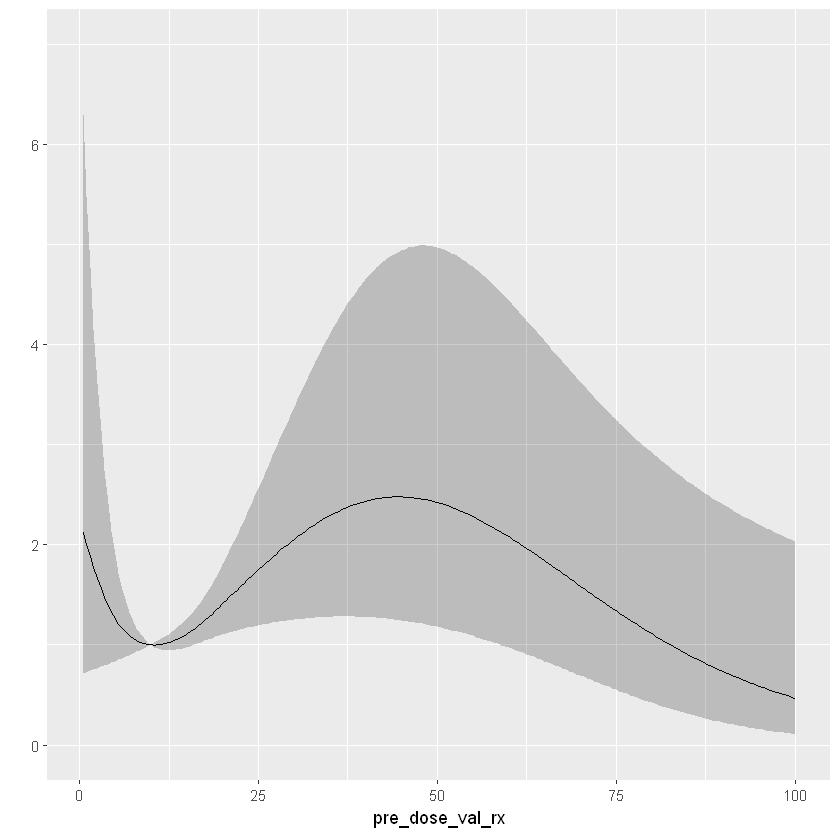

In [91]:
P1<-ggplot(HR)
P1

[1]  9.5 10.0 10.5 11.0 11.5 82.5

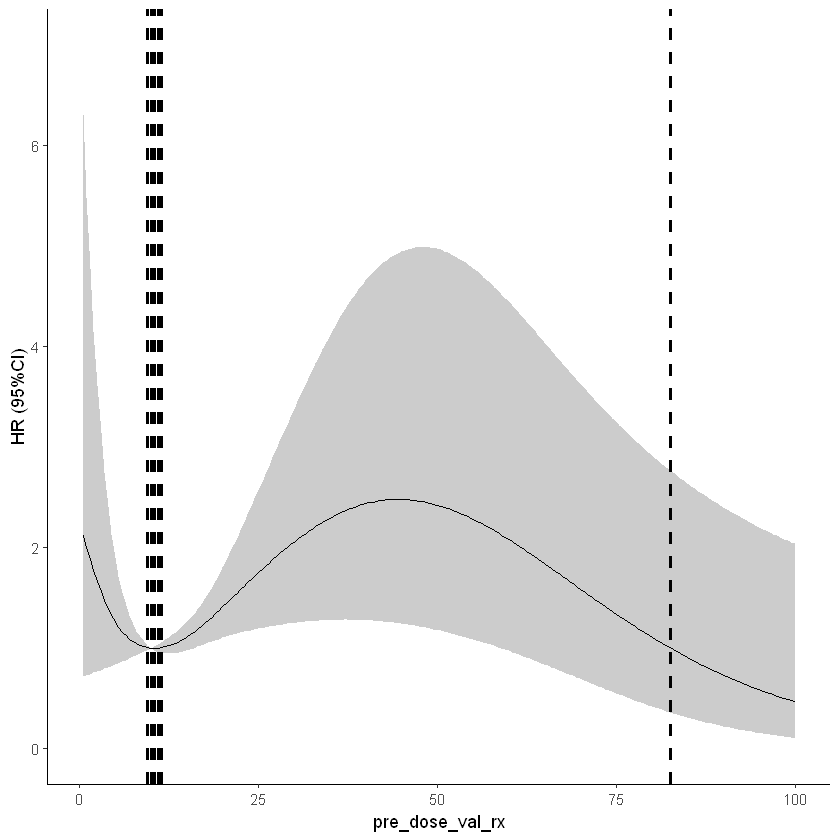

In [92]:

P2 <- ggplot(HR, aes(x=pre_dose_val_rx, y=yhat)) + theme_classic() + labs(x="tyg",y="HR (95%CI)")

x_values <- HR$pre_dose_val_rx[abs(HR$yhat - 1) < 0.01]
x_values
for (x in x_values) {
  P2 <- P2 + geom_vline(xintercept=x, linetype=2, size=1) +
  labs(x="pre_dose_val_rx",y="HR (95%CI)") 
}

P2

In [122]:
find_non_crossing_intervals <- function(df) {
  df_filtered <- df[(df$lower > 1 & df$upper > 1) | (df$lower < 1 & df$upper < 1), ]
  return(df_filtered)
}

HR_filtered <- find_non_crossing_intervals(HR)


pre_dose_val_rx,yhat,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>


In [94]:
# find the line for the maximum value of HR
max_HR_row <- HR_filtered[which.max(HR_filtered$yhat), ]


# get the valuefrom this line
max_HR_pre_dose_val_rx <- max_HR_row$pre_dose_val_rx


print(max_HR_pre_dose_val_rx)

[1] 44.5


In [95]:
# find the line for the maximum value of HR
max_HR_row <- HR_filtered[which.min(HR_filtered$yhat), ]

# get the value from this line
max_HR_pre_dose_val_rx <- max_HR_row$pre_dose_val_rx


print(max_HR_pre_dose_val_rx)

[1] 16


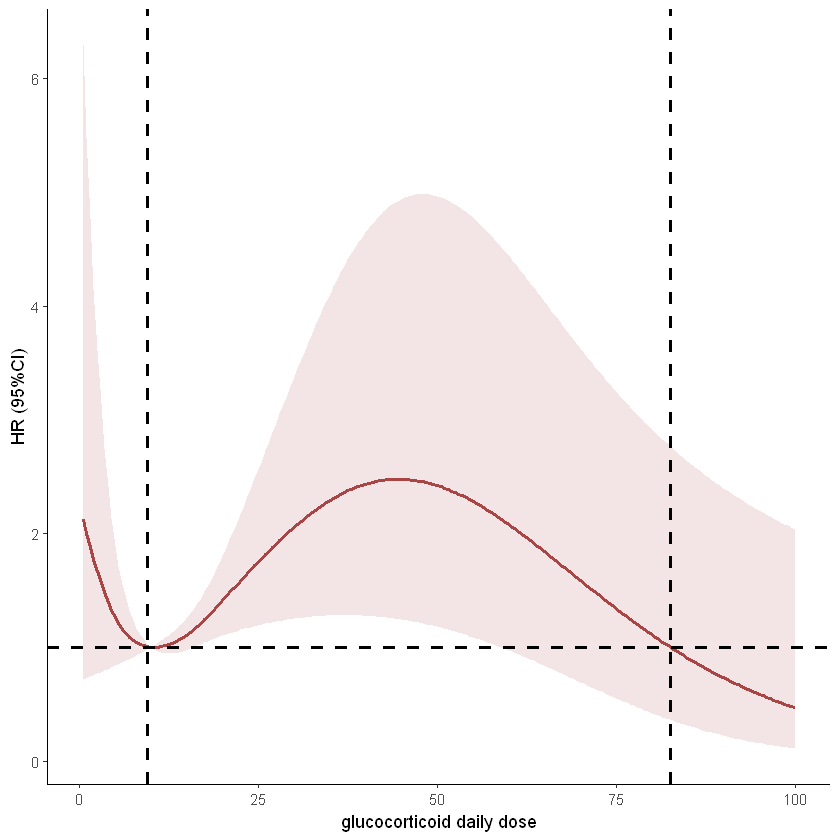

In [96]:
P2 <- ggplot()+ geom_line(data=HR,aes(pre_dose_val_rx,yhat),linetype="solid", size=1,alpha = 0.7,colour="darkred")+ geom_ribbon(data=HR, aes(pre_dose_val_rx, ymin = lower, ymax = upper),alpha = 0.1,fill="darkred") 
P2 <- P2 + theme_classic() + geom_hline(yintercept = 1, linetype="dashed", size=1) +
geom_vline(xintercept = 9.5,linetype=2,size=1) + geom_vline(xintercept = 82.5,linetype=2,size=1) +  labs(x="glucocorticoid daily dose",y="HR (95%CI)") 
P2

In [97]:
full_data$pre_dose_val_rx <- as.numeric(full_data$pre_dose_val_rx)
full_data$pre_dose_group <- cut(full_data$pre_dose_val_rx, 
                           breaks = c(-Inf, 16, 44.5, Inf),
                           labels = c("Low", "Medium", "High"))

In [98]:
m1 <- read.csv(file.path(data_dir, "ps_df.csv"))
colnames(m1)
m1$pre_dose_val_rx <- as.numeric(m1$pre_dose_val_rx)

[1] "stay_id"                        "group"                         
  [3] "match"                          "hadm_id"                       
  [5] "subject_id"                     "gender"                        
  [7] "age"                            "sapsii"                        
  [9] "icu_intime"                     "icu_outtime"                   
 [11] "weight"                         "sofa_24hours"                  
 [13] "infection"                      "mort_28_day"                   
 [15] "survival_days"                  "gcs_include"                   
 [17] "gcs_include_combine"            "vs_heart_rate_first"           
 [19] "vs_heart_rate_min"              "vs_heart_rate_max"             
 [21] "vs_cvp_first"                   "vs_cvp_min"                    
 [23] "vs_cvp_max"                     "vs_map_first"                  
 [25] "vs_map_min"                     "vs_map_max"                    
 [27] "vs_temp_first"                  "vs_temp_min"                   
 [29] "vs_temp_max"                    "lab_hemoglobin_first"          
 [31] "lab_hemoglobin_min"             "lab_hemoglobin_max"            
 [33] "lab_hemoglobin_abnormal"        "lab_platelet_first"            
 [35] "lab_platelet_min"               "lab_platelet_max"              
 [37] "lab_platelet_abnormal"          "lab_creatinine_kinase_first"   
 [39] "lab_creatinine_kinase_min"      "lab_creatinine_kinase_max"     
 [41] "lab_creatinine_kinase_abnormal" "lab_wbc_first"                 
 [43] "lab_wbc_min"                    "lab_wbc_max"                   
 [45] "lab_wbc_abnormal"               "lab_ph_first"                  
 [47] "lab_ph_min"                     "lab_ph_max"                    
 [49] "lab_ph_abnormal"                "lab_chloride_first"            
 [51] "lab_chloride_min"               "lab_chloride_max"              
 [53] "lab_chloride_abnormal"          "lab_sodium_first"              
 [55] "lab_sodium_min"                 "lab_sodium_max"                
 [57] "lab_sodium_abnormal"            "lab_bun_first"                 
 [59] "lab_bun_min"                    "lab_bun_max"                   
 [61] "lab_bun_abnormal"               "lab_bicarbonate_first"         
 [63] "lab_bicarbonate_min"            "lab_bicarbonate_max"           
 [65] "lab_bicarbonate_abnormal"       "lab_pco2_first"                
 [67] "lab_pco2_min"                   "lab_pco2_max"                  
 [69] "lab_pco2_abnormal"              "lab_creatinine_first"          
 [71] "lab_creatinine_min"             "lab_creatinine_max"            
 [73] "lab_creatinine_abnormal"        "lab_potassium_first"           
 [75] "lab_potassium_min"              "lab_potassium_max"             
 [77] "lab_potassium_abnormal"         "lab_troponin_first"            
 [79] "lab_troponin_min"               "lab_troponin_max"              
 [81] "lab_troponin_abnormal"          "lab_po2_first"                 
 [83] "lab_po2_min"                    "lab_po2_max"                   
 [85] "lab_po2_abnormal"               "lab_lactate_first"             
 [87] "lab_lactate_min"                "lab_lactate_max"               
 [89] "lab_lactate_abnormal"           "pre_dose_val_rx"               
 [91] "los_drug"                       "cumulative_dose"               
 [93] "gcs"                            "ca"                            
 [95] "infection_flag"                 "dose_val_rx_average"           
 [97] "los_drug_average"               "event_state"                   
 [99] "vs_heart_rate_flag"             "vs_cvp_flag"                   
[101] "vs_map_flag"                    "vs_temp_flag"                  
[103] "lab_hemoglobin_flag"            "lab_platelet_flag"             
[105] "lab_creatinine_kinase_flag"     "lab_wbc_flag"                  
[107] "lab_ph_flag"                    "lab_chloride_flag"             
[109] "lab_sodium_flag"                "lab_bun_flag"                  
[111] "lab_bicarbonate_flag"           "la

In [99]:
# Further subgroup analysis after stratification by age, drug dosage, and various other indicators
head(m1)

,stay_id,group,match,hadm_id,subject_id,gender,age,sapsii,icu_intime,icu_outtime,⋯,lab_potassium_flag,lab_troponin_flag,lab_po2_flag,lab_lactate_flag,gcs_int,ca_int,event_state_int,mort_28_day_int,ps,ps_weight
,<int>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,31869153,trtd,1,21383344,15359363,F,41.91122,39,2166-12-02T16:08:45Z,2166-12-05T02:10:02Z,⋯,1,0,0,0,1,NA,0,0,0.57470795,1.740014
2,39943969,trtd,2,21237030,19839346,F,57.41306,55,2129-06-01T17:03:32Z,2129-06-14T18:11:11Z,⋯,1,0,1,1,1,1,1,1,0.22189905,4.506554
3,31592145,trtd,3,23461808,18507152,M,75.20097,36,2142-03-17T18:24:17Z,2142-03-18T21:35:30Z,⋯,1,0,0,0,1,0,1,0,0.08418521,11.878571
4,34069747,trtd,4,28293583,15756685,M,64.57062,49,2196-08-21T01:15:25Z,2196-09-03T01:09:34Z,⋯,1,0,1,1,1,1,0,0,0.48884097,2.045655
5,30928501,trtd,5,23312997,12137322,F,73.23301,35,2125-03-28T00:34:22Z,2125-03-29T10:04:51Z,⋯,1,0,1,1,1,0,0,0,0.22218050,4.500845
6,30384294,trtd,6,22084837,17011637,F,40.92149,13,2132-12-03T17:25:47Z,2132-12-06T15:22:54Z,⋯,1,0,1,1,1,NA,0,0,0.21603559,4.628867


In [100]:
 dd <- datadist(m1) 
 head(m1) 

Warning message in datadist(m1):
"lab_hemoglobin_abnormal is constant"


,stay_id,group,match,hadm_id,subject_id,gender,age,sapsii,icu_intime,icu_outtime,⋯,lab_potassium_flag,lab_troponin_flag,lab_po2_flag,lab_lactate_flag,gcs_int,ca_int,event_state_int,mort_28_day_int,ps,ps_weight
,<int>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,31869153,trtd,1,21383344,15359363,F,41.91122,39,2166-12-02T16:08:45Z,2166-12-05T02:10:02Z,⋯,1,0,0,0,1,NA,0,0,0.57470795,1.740014
2,39943969,trtd,2,21237030,19839346,F,57.41306,55,2129-06-01T17:03:32Z,2129-06-14T18:11:11Z,⋯,1,0,1,1,1,1,1,1,0.22189905,4.506554
3,31592145,trtd,3,23461808,18507152,M,75.20097,36,2142-03-17T18:24:17Z,2142-03-18T21:35:30Z,⋯,1,0,0,0,1,0,1,0,0.08418521,11.878571
4,34069747,trtd,4,28293583,15756685,M,64.57062,49,2196-08-21T01:15:25Z,2196-09-03T01:09:34Z,⋯,1,0,1,1,1,1,0,0,0.48884097,2.045655
5,30928501,trtd,5,23312997,12137322,F,73.23301,35,2125-03-28T00:34:22Z,2125-03-29T10:04:51Z,⋯,1,0,1,1,1,0,0,0,0.22218050,4.500845
6,30384294,trtd,6,22084837,17011637,F,40.92149,13,2132-12-03T17:25:47Z,2132-12-06T15:22:54Z,⋯,1,0,1,1,1,NA,0,0,0.21603559,4.628867


In [101]:
options(datadist='dd') 

In [102]:

m3<- cph(Surv(survival_days, mort_28_day) ~ rcs(pre_dose_val_rx,4),x=TRUE , y=TRUE,data = m1) 

In [103]:
anova(m3) 

,Chi-Square,d.f.,P
pre_dose_val_rx,7.059017,3,0.07004031
Nonlinear,6.805855,2,0.03327571
TOTAL,7.059017,3,0.07004031


In [104]:

HR<-Predict(m3, pre_dose_val_rx,fun=exp,ref.zero = TRUE ) 
View(HR)
colnames(HR)


pre_dose_val_rx,yhat,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
1.000000,2.5057008,0.7449735,8.427865
1.497487,2.2886913,0.7560270,6.928467
1.994975,2.0904763,0.7671661,5.696408
2.492462,1.9094500,0.7783621,4.684194
2.989950,1.7453270,0.7896001,3.857860
3.487437,1.5992082,0.8009031,3.193229
3.984925,1.4715862,0.8123072,2.665945
4.482412,1.3624224,0.8238693,2.253021
4.979899,1.2713818,0.8356891,1.934226


[1] "pre_dose_val_rx" "yhat"            "lower"           "upper"

In [105]:
find_non_crossing_intervals <- function(df) {
  df_filtered <- df[(df$lower > 1 & df$upper > 1) | (df$lower < 1 & df$upper < 1), ]
  return(df_filtered)
}

HR_filtered <- find_non_crossing_intervals(HR)
HR_filtered


,pre_dose_val_rx,yhat,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
23,11.94472,1.063770,1.000460,1.131086
24,12.44221,1.088865,1.007269,1.177070
25,12.93970,1.116818,1.015216,1.228588
26,13.43719,1.147221,1.023822,1.285494
27,13.93467,1.179621,1.032729,1.347406
28,14.43216,1.213506,1.041666,1.413694
29,14.92965,1.248303,1.050418,1.483466
30,15.42714,1.283436,1.058828,1.555690
31,15.92462,1.318713,1.066901,1.629958


In [106]:
# 找到HR的最大值对应的行
max_HR_row <- HR_filtered[which.max(HR_filtered$yhat), ]

# 从这一行中获取pre_dose_val_rx的值
max_HR_pre_dose_val_rx <- max_HR_row$pre_dose_val_rx

# 打印结果
print(max_HR_pre_dose_val_rx)

[1] 40.30151


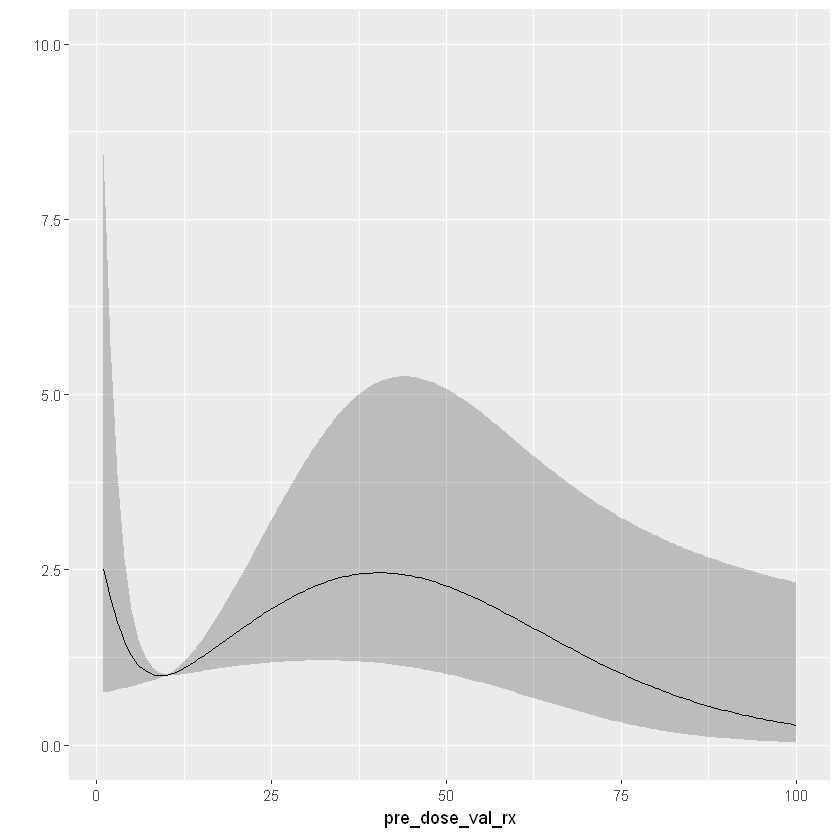

In [107]:
P1<-ggplot(HR)
P1

[1]  8.462312  8.959799  9.457286  9.954774 10.452261 75.623116

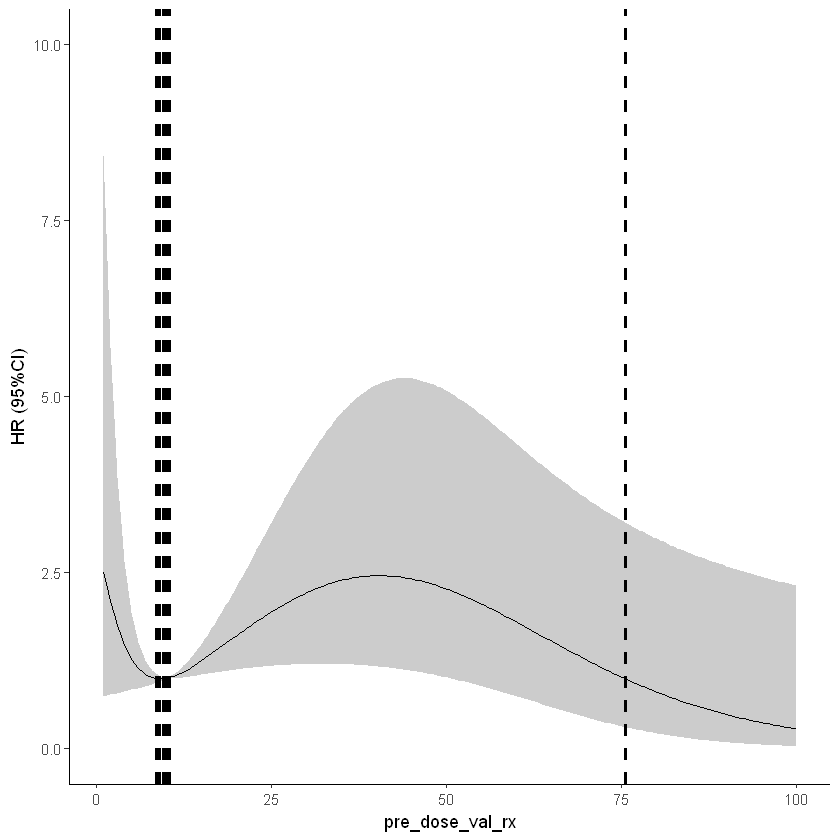

In [108]:
# 创建一个基础图表
P2 <- ggplot(HR, aes(x=pre_dose_val_rx, y=yhat)) + theme_classic() + labs(x="GCs",y="HR (95%CI)")

x_values <- HR$pre_dose_val_rx[abs(HR$yhat - 1) < 0.01]
x_values
for (x in x_values) {
  P2 <- P2 + geom_vline(xintercept=x, linetype=2, size=1) +
  labs(x="pre_dose_val_rx",y="HR (95%CI)") 
}

P2

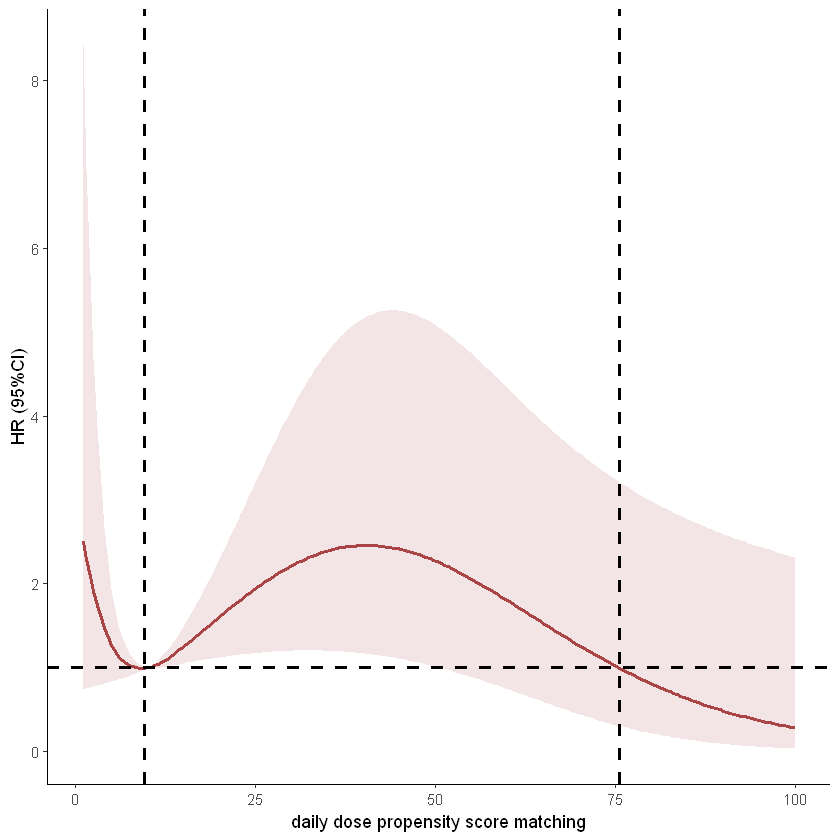

In [109]:
P2 <- ggplot()+ geom_line(data=HR,aes(pre_dose_val_rx,yhat),linetype="solid", size=1,alpha = 0.7,colour="darkred")+ geom_ribbon(data=HR, aes(pre_dose_val_rx, ymin = lower, ymax = upper),alpha = 0.1,fill="darkred") 
P2 <- P2 + theme_classic() + geom_hline(yintercept = 1, linetype="dashed", size=1) +
geom_vline(xintercept = 9.46,linetype=2,size=1) + geom_vline(xintercept = 75.6,linetype=2,size=1) +  labs(x="daily dose propensity score matching",y="HR (95%CI)") 
P2

In [120]:
HR <- Predict(m3, pre_dose_val_rx = 82.5778894472362, fun = exp, ref.zero = TRUE)
HR

pre_dose_val_rx,yhat,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
82.57789,0.7130226,0.176996,2.872387


In [121]:
find_non_crossing_intervals <- function(df) {
  df_filtered <- df[(df$lower > 1 & df$upper > 1) | (df$lower < 1 & df$upper < 1), ]
  return(df_filtered)
}

HR_filtered <- find_non_crossing_intervals(HR)
HR_filtered

pre_dose_val_rx,yhat,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>


In [112]:
# 找到HR的最大值对应的行
max_HR_row <- HR_filtered[which.max(HR_filtered$yhat), ]

# 从这一行中获取pre_dose_val_rx的值
max_HR_pre_dose_val_rx <- max_HR_row$pre_dose_val_rx

# 打印结果
print(max_HR_pre_dose_val_rx)

numeric(0)


In [113]:
# # find the line for the maximum value of HR
max_HR_row <- HR_filtered[which.max(HR_filtered$yhat), ]

# Get the values for pre, lower, and upper from this line
max_HR_pre_dose_val_rx <- max_HR_row$pre_dose_val_rx
lower <- max_HR_row$lower
upper <- max_HR_row$upper

print(max_HR_pre_dose_val_rx)
print(max_HR_row)


numeric(0)
[1] pre_dose_val_rx yhat            lower           upper          
<0 rows> (or 0-length row.names)

Response variable (y):  

Limits are 0.95 confidence limits


In [114]:
# get the values pre, lower, and upper from this line
max_HR_row <- HR_filtered[which.min(HR_filtered$yhat), ]

# get the values pre, lower, and upper from this line
max_HR_pre_dose_val_rx <- max_HR_row$pre_dose_val_rx
lower <- max_HR_row$lower
upper <- max_HR_row$upper


print(max_HR_pre_dose_val_rx)
print(max_HR_row)


numeric(0)
[1] pre_dose_val_rx yhat            lower           upper          
<0 rows> (or 0-length row.names)

Response variable (y):  

Limits are 0.95 confidence limits


In [115]:
feature_names <- full_data %>%
    names %>%
    keep(grepl("vs|lab|age|gender|weight|sapsii|sofa|sofa_24hours|event_state|cam_state|gcs|flag|pre_dose_val_rx", .)) %>%
    discard(grepl("vs|lab", .) & grepl("flag", .) & !grepl("bnp|troponin|kinase|cvp", .)) %>%
    discard(grepl("first|min|max|gcs_include", .)) %>%
    discard(grepl("abnormal", .))
feature_names
length(feature_names)

[1] "gender"                     "age"                       
 [3] "sapsii"                     "weight"                    
 [5] "sofa_24hours"               "pre_dose_val_rx"           
 [7] "gcs"                        "infection_flag"            
 [9] "dose_val_rx_average"        "los_drug_average"          
[11] "event_state"                "vs_cvp_flag"               
[13] "lab_creatinine_kinase_flag" "lab_bnp_flag"              
[15] "lab_troponin_flag"          "gcs_int"                   
[17] "event_state_int"            "ps_weight"

[1] 18

In [116]:
# 年龄分组
m1$age_group <- cut(m1$age, breaks = c(-Inf, 55, 70, Inf), 
                          labels = c("Young<55", "Middle55-70", "Old>70"))

# 体重分组 
m1$weight_group <- cut(m1$weight, breaks = c(-Inf, 70, 90, Inf),
                             labels = c("Light<70", "Normal70-90", "Heavy>90"))

# SAPSII分组
m1$sapsii_group <- cut(m1$sapsii, breaks = c(-Inf, 35, 45, Inf),
                             labels = c("Low<35", "Medium35-45", "High>45"))

# SOFA 24hours分组
m1$sofa_24hours_group <- cut(m1$sofa_24hours, breaks = c(-Inf, 3, 5, Inf), 
                                   labels = c("Mild<3", "Moderate3-5", "Severe>5"))

# WBC分组
m1$wbc_group <- cut(m1$lab_wbc_first, breaks = c(-Inf, 8, 15, Inf),
                          labels = c("Low<8", "Normal8-15", "High>15"))

# pH分组
m1$ph_group <- cut(m1$lab_ph_first, breaks = c(-Inf, 7.3, 7.5, Inf),
                         labels = c("Acidic<7.3", "Normal7.3-7.5", "Alkaline>7.5"))


m1$dose_group <- cut(m1$cumulative_dose, 
                           breaks = c(-Inf, 1888, 2830, Inf),
                           labels = c("Low", "Medium", "High"))
m1$pre_dose_val_rx <- as.numeric(m1$pre_dose_val_rx)
m1$pre_dose_group <- cut(m1$pre_dose_val_rx, 
                           breaks = c(-Inf, 12, 50, Inf),
                           labels = c("Low", "Medium", "High"))

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
"Unable to resize forest panel to be smaller than its heading; consider a smaller text size"


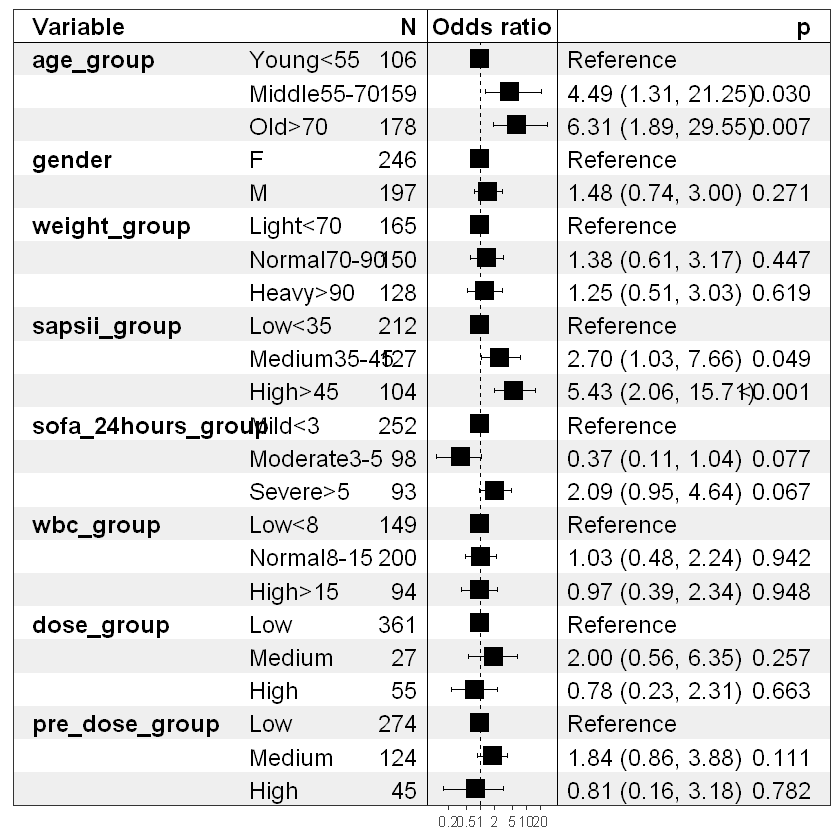

In [117]:
# 建立logistic回归模型
model <- glm(mort_28_day ~ age_group + gender + weight_group + sapsii_group + sofa_24hours_group + wbc_group + dose_group +pre_dose_group,
              family = binomial(), data = m1)

# 绘制森林图
library(forestmodel)
forest_model(model)